In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits

In [17]:
plt.style.use('notebook')

In [18]:
t = Table.read('../data/rcat.fits')
ind = np.isfinite(t['GAIADR2_PMRA']) & (t['FLAG']==0) & (t['SNR']>10) & (t['E_tot_pot1']<0)
t = t[ind]
print(len(t))

age = 10**t['logAge']*1e-9
age_lerr = age - 10**(t['logAge']-t['logAge_lerr'])*1e-9
age_uerr = 10**(t['logAge']+t['logAge_uerr'])*1e-9 - age
age_err = 0.5 * (age_lerr + age_uerr)
age_err_cons = np.maximum(age_lerr, age_uerr)
age_err_min = 1
age_err_cons[age_err_cons<age_err_min] = age_err_min
age_invar = (age_err_cons)**-2

27962


In [19]:
blue = '#0039d3'
purple = '#4700d3'
orange = '#ff6200'
pink = '#ee0449'

In [20]:
ind_all = np.ones(len(t), dtype='bool')
ind_z = (np.abs(t['Z_gal'])<1)
loggmin, loggmax = 3.8, 4.3
ind_safeage = (t['logg']>loggmin) & (t['logg']<loggmax) #& (t['logg_err']<0.1)
# ind_safeage = (t['logg']>3.8) & (t['logg']<4.3) & (age_err/age<0.15)
print(np.sum(ind_safeage))

11034


In [21]:
ind_highe = (t['eccen_pot1']>0.75)
ind_lowe = (t['eccen_pot1']<0.25)

p_ge = [-0.32,-0.02]
poly_ge = np.poly1d(p_ge)

p_splash = [-0.1,0.18]
p_splash = [-0.14,0.18]
poly_splash = np.poly1d(p_splash)

p_lowa = [-0.16,0.1]
p_lowa = [-0.14,0.15]
# p_lowa = [-0.2,0.1]
poly_lowa = np.poly1d(p_lowa)

ind_trap = ((t['init_FeH']>-0.5) & (t['init_FeH']<-0.1) & (t['init_aFe']>0.0) 
            & (t['init_aFe']<poly_lowa(t['init_FeH'])))
ind_lowa = ind_trap & ind_lowe
ind_lowa = ind_lowe & (t['init_FeH']>-0.45) & (t['init_aFe']<poly_lowa(t['init_FeH'])) & (t['init_FeH']<-0.1)
ind_mpoor = (t['init_FeH']<-0.6) & (t['init_aFe']<poly_ge(t['init_FeH']))
ind_ge = ind_mpoor & ind_highe
ind_tdchem = (t['init_FeH']>-0.75) & (t['init_aFe']>poly_splash(t['init_FeH']))
ind_splash = ind_tdchem & ind_highe
ind_thick = ind_tdchem & ind_lowe

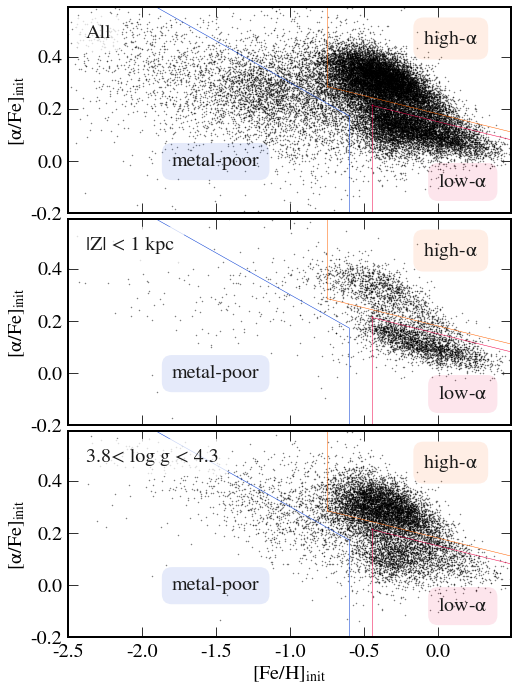

In [46]:
x_ge = np.linspace(-2, -0.6, 30)
y_ge = poly_ge(x_ge)

x_splash = np.linspace(-0.75, 0.5, 30)
y_splash = poly_splash(x_splash)

x_lowa = np.linspace(-0.45, 0.5, 30)
y_lowa = poly_lowa(x_lowa)

afeh_panels = ['All', '|Z| < 1 kpc', '{:.1f}< log g < {:.1f}'.format(loggmin, loggmax)]

fig, ax = plt.subplots(3,1,figsize=(7.5,10), sharex=True, sharey=True)

for e, ind in enumerate([ind_all, ind_z, ind_safeage]):
    plt.sca(ax[e])
    plt.plot(t['init_FeH'][ind], t['init_aFe'][ind], 'ko', mew=0, ms=1.5, alpha=0.5, rasterized=True)

    plt.plot(x_ge, y_ge, '-', color=blue, label='', lw=0.5)
    plt.plot([-0.6, -0.6], [-0.2, poly_ge(-0.6)], '-', color=blue, label='', lw=0.5)
    plt.plot(x_splash, y_splash, '-', color=orange, label='', lw=0.5)
    plt.plot([-0.75, -0.75], [poly_splash(-0.75), 0.6], '-', color=orange, label='', lw=0.5)
    plt.plot(x_lowa, y_lowa, '-', color=pink, label='', lw=0.5)
    plt.plot([-0.45, -0.45], [-0.2, poly_lowa(-0.5)], '-', color=pink, label='', lw=0.5)
    
    plt.text(-0.1, 0.45, 'high-$\\alpha$', color='0.1',
         bbox=dict(facecolor=orange, ec='none', alpha=0.1, boxstyle='round', pad=0.5))
    plt.text(0, -0.1, 'low-$\\alpha$', color='0.1',
         bbox=dict(facecolor=pink, ec='none', alpha=0.1, boxstyle='round', pad=0.5))
    plt.text(-1.8, -0.02, 'metal-poor', color='0.1',
             bbox=dict(facecolor=blue, ec='none', alpha=0.1, boxstyle='round', pad=0.5))

    plt.text(0.04, 0.85, afeh_panels[e], color='0.1', transform=plt.gca().transAxes,
             bbox=dict(facecolor='w', ec='none', alpha=0.75, boxstyle='round', pad=0.5))
    plt.ylabel('[$\\alpha$/Fe]$_{init}$')
    
plt.xlim(-2.5,0.49)
plt.ylim(-0.2, 0.59)
plt.xlabel('[Fe/H]$_{init}$')
plt.tight_layout(h_pad=0.3)
plt.savefig('../paper/afeh_selections.pdf')

In [23]:
rcyl = np.sqrt(t['X_gal']**2 + t['Y_gal']**2)

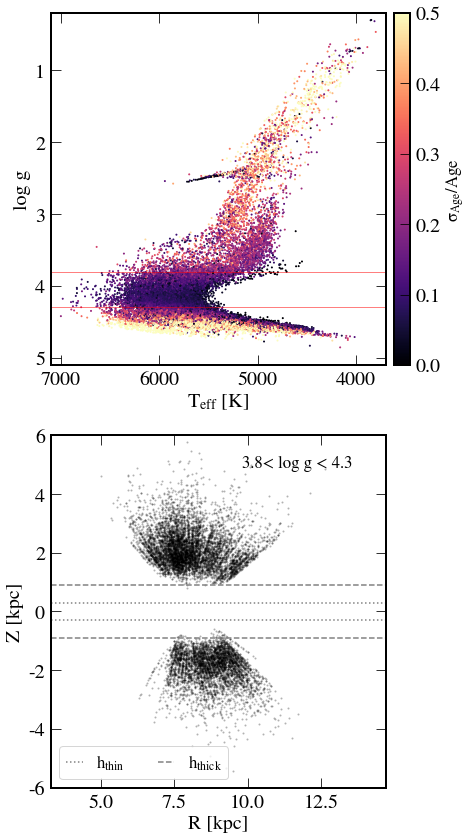

In [49]:
fig, ax = plt.subplots(2,1,figsize=(6,14.25), gridspec_kw=dict(hspace=0.2))

plt.sca(ax[0])
im = plt.scatter(t['Teff'], t['logg'], c=age_err/age, vmin=0, vmax=0.5, s=1, cmap='magma', rasterized=True)
plt.axhline(loggmin, ls='-', color='r', alpha=0.5, lw=1)
plt.axhline(loggmax, ls='-', color='r', alpha=0.5, lw=1)

plt.xlim(7100,3700)
plt.ylim(5.1,0.2)
plt.xlabel('$T_{eff}$ [K]')
plt.ylabel('log g')

pos = plt.gca().get_position()
cax = plt.axes([pos.x1+0.02,pos.y0,0.035,pos.y1 - pos.y0])
plt.colorbar(im, cax=cax) #, ticks=[-5,-2.5,0,2.5,5])
# plt.yticks(fontsize=font_tick)
plt.ylabel('$\sigma_{Age} / Age$', fontsize='small')

plt.sca(ax[1])
plt.plot(rcyl[ind_safeage], t['Z_gal'][ind_safeage], 'ko', mew=0, ms=2, alpha=0.3, label='', rasterized=True)

ls = [':', '--']
labels = ['$h_{thin}$', '$h_{thick}$']
for e, h in enumerate([0.3, 0.9]):
    plt.axhline(h, color='0.5', ls=ls[e], label=labels[e])
    plt.axhline(-h, color='0.5', ls=ls[e], label='')

plt.text(0.9,0.91,'{:.1f}< log g < {:.1f}'.format(loggmin, loggmax), fontsize='small', transform=plt.gca().transAxes,
        ha='right')
plt.legend(loc=3, fontsize='small', handlelength=1, ncol=2)
plt.ylim(-6,6)
plt.xlim(5,13)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R [kpc]')
plt.ylabel('Z [kpc]')

# plt.tight_layout()
plt.savefig('../paper/sample.pdf')

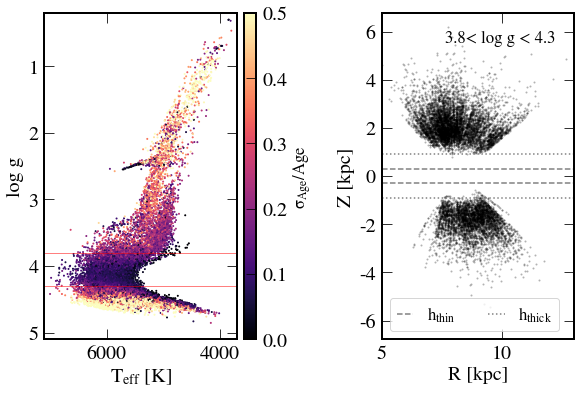

In [24]:
fig, ax = plt.subplots(1,2,figsize=(9.5,6), gridspec_kw=dict(wspace=0.75))

plt.sca(ax[0])
im = plt.scatter(t['Teff'], t['logg'], c=age_err/age, vmin=0, vmax=0.5, s=1, cmap='magma')
plt.axhline(loggmin, ls='-', color='r', alpha=0.5, lw=1)
plt.axhline(loggmax, ls='-', color='r', alpha=0.5, lw=1)

plt.xlim(7100,3700)
plt.ylim(5.1,0.2)
plt.xlabel('$T_{eff}$ [K]')
plt.ylabel('log g')

pos = plt.gca().get_position()
cax = plt.axes([pos.x1+0.01,pos.y0,0.018,pos.y1 - pos.y0])
plt.colorbar(im, cax=cax) #, ticks=[-5,-2.5,0,2.5,5])
# plt.yticks(fontsize=font_tick)
plt.ylabel('$\sigma_{Age} / Age$', fontsize='small')

plt.sca(ax[1])
plt.plot(rcyl[ind_safeage], t['Z_gal'][ind_safeage], 'ko', mew=0, ms=2, alpha=0.3, label='')

ls = ['--', ':']
labels = ['$h_{thin}$', '$h_{thick}$']
for e, h in enumerate([0.3, 0.9]):
    plt.axhline(h, color='0.5', ls=ls[e], label=labels[e])
    plt.axhline(-h, color='0.5', ls=ls[e], label='')

plt.text(0.9,0.91,'{:.1f}< log g < {:.1f}'.format(loggmin, loggmax), fontsize='small', transform=plt.gca().transAxes,
        ha='right')
plt.legend(loc=3, fontsize='small', handlelength=1, ncol=2)
plt.ylim(-6,6)
plt.xlim(5,13)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R [kpc]')
plt.ylabel('Z [kpc]')

# plt.tight_layout()
plt.savefig('../paper/sample.png')

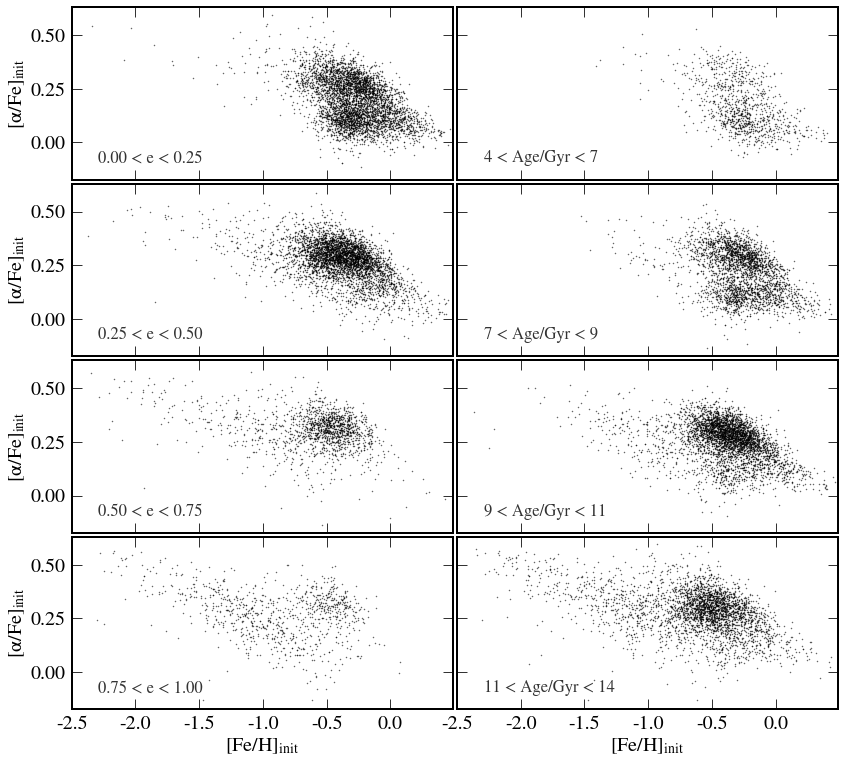

In [25]:
ecc_ranges = np.array([0,0.25,0.5,0.75,1])
age_ranges = np.array([4,7,9,11,14])
Ne = np.size(ecc_ranges) - 1

da = 6
fig, ax = plt.subplots(Ne,2,figsize=(12,11), sharey=True, sharex=True)

for i in range(Ne):
    ind = (t['eccen_pot1']>=ecc_ranges[i]) & (t['eccen_pot1']<ecc_ranges[i+1])
    
    plt.sca(ax[i][0])
    plt.plot(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind], 'ko', mew=0, ms=1.5, alpha=0.6,
            label='')

    plt.xlim(-2.5,0.49)
    plt.ylabel('[$\\alpha$/Fe]$_{init}$')
    plt.text(0.07,0.1,'{:.2f} < e < {:.2f}'.format(ecc_ranges[i], ecc_ranges[i+1]), fontsize='small',
            transform=plt.gca().transAxes, color='0.2')
    
    # right column
    plt.sca(ax[i][1])
    ind = (age>=age_ranges[i]) & (age<age_ranges[i+1])
    plt.plot(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind], 'ko', mew=0, ms=1.5, alpha=0.6,
            label='')
    plt.text(0.07,0.1,'{:.0f} < Age/Gyr < {:.0f}'.format(age_ranges[i], age_ranges[i+1]), fontsize='small',
            transform=plt.gca().transAxes, color='0.2')
    
for j in range(2):
    plt.sca(ax[Ne-1][j])
    plt.xlabel('[Fe/H]$_{init}$')

plt.tight_layout(w_pad=0.2, h_pad=0.2)
plt.savefig('../paper/afeh_eccen_age.png')

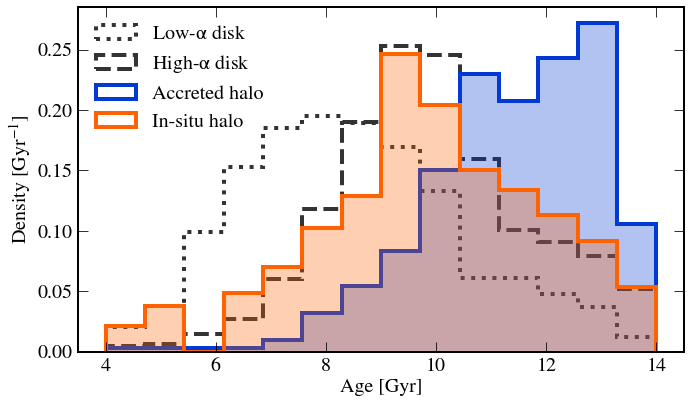

In [37]:
abins = np.linspace(4,14,15)

plt.figure(figsize=(10,6))

plt.hist(age[ind_safeage & ind_lowa], color='0.2', bins=abins, alpha=1, density=True,
         label='Low-$\\alpha$ disk', histtype='step', ls=':', lw=4)
plt.hist(age[ind_safeage & ind_thick], color='0.2', bins=abins, alpha=1, density=True,
         label='High-$\\alpha$ disk', histtype='step', ls='--', lw=4)
# plt.hist(age[ind_safeage & ind_lowa], color=pink, bins=abins, alpha=0.3, density=True, label='')
# plt.hist(age[ind_safeage & ind_lowa], color=pink, bins=abins, alpha=1, density=True,
#          label='Low-$\\alpha$ disk', histtype='step', ls='-', lw=4)
plt.hist(age[ind_safeage & ind_ge], color=blue, bins=abins, alpha=0.3, density=True, label='')
plt.hist(age[ind_safeage & ind_ge], color=blue, bins=abins, density=True, histtype='step', lw=4,
         label='Accreted halo')
plt.hist(age[ind_safeage & ind_splash], color=orange, bins=abins, alpha=0.3, density=True, label='')
plt.hist(age[ind_safeage & ind_splash], color=orange, bins=abins, density=True, histtype='step', lw=4,
         label='In-situ halo')

plt.legend(loc=2, frameon=False)
plt.xlabel('Age [Gyr]')
plt.ylabel('Density [Gyr$^{-1}$]')

plt.tight_layout()
plt.savefig('../paper/ages.png')